## build a stock price predictor
## backtesting
## investment portfolio management

In [394]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas_datareader.data as web # fetch stock data

%matplotlib inline

In [638]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2018, 1, 1)
f = web.DataReader('AAPL', 'yahoo', start, end)

In [639]:
f.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,79.575714,78.860001,79.382858,79.018570,58671200.0,66.964325
2014-01-03,79.099998,77.204285,78.980003,77.282860,98116900.0,65.493416
2014-01-06,78.114288,76.228569,76.778572,77.704285,103152700.0,65.850533
2014-01-07,77.994286,76.845711,77.760002,77.148575,79302300.0,65.379593
2014-01-08,77.937141,76.955711,76.972855,77.637146,64632400.0,65.793633


In [640]:
# format stock data, round to 2 decimal place
def format_data(df=f):
    columns = df.columns
    for col in columns:
        df[col] = df[col].apply(lambda x: round(x,5))
    return df

f = format_data(f)

In [641]:
f.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,79.57571,78.86000,79.38286,79.01857,58671200.0,66.96432
2014-01-03,79.10000,77.20428,78.98000,77.28286,98116900.0,65.49342
2014-01-06,78.11429,76.22857,76.77857,77.70428,103152700.0,65.85053
2014-01-07,77.99429,76.84571,77.76000,77.14857,79302300.0,65.37959
2014-01-08,77.93714,76.95571,76.97285,77.63715,64632400.0,65.79363


# Feature Engineering
state: holding a stock or not, bollinger band, adj close/sma, P/E ratio, return since enter market, volumn


In [642]:
f['norm_adj_close'] = f['Adj Close']/f.loc['2014-01-02','Adj Close']

In [643]:
f.head(2)

,High,Low,Open,Close,Volume,Adj Close,norm_adj_close
Date,,,,,,,
2014-01-02,79.57571,78.86000,79.38286,79.01857,58671200.0,66.96432,1.000000
2014-01-03,79.10000,77.20428,78.98000,77.28286,98116900.0,65.49342,0.978035


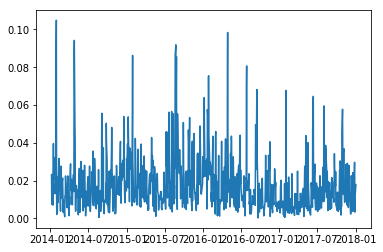

In [644]:
def get_bollinger_bands(values, window):
    '''
    Return upper and lower Bollinger Bands.
    INPUTS:
    values(pandas series)
    window(int): time period to consider
    OUTPUS:
    upper_band(pandas series)
    lower_band(pandas series)
    '''
    #  rolling mean
    rm = values.rolling(window=window).mean()
    rstd = values.rolling(window=window).std()
    
    band_width = 2. * rstd / rm
    return band_width.apply(lambda x: round(x,5))

plt.plot(get_bollinger_bands(f['Close'], 3));

bb_width = get_bollinger_bands(f['Close'], 3)

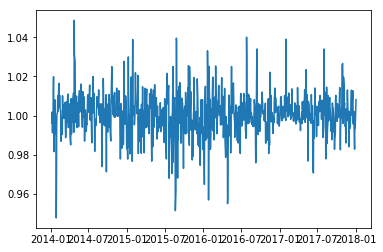

In [645]:
def get_adj_close_sma_ratio(values, window):
    '''
    Return the ratio of adjusted closing value to the simple moving average.
    INPUTS:
    values(pandas series)
    window(int): time period to consider
    OUTPUS:
    '''
    rm = values.rolling(window=window).mean()
    ratio = values/rm
    return ratio.apply(lambda x: round(x,5))

plt.plot(get_adj_close_sma_ratio(f['Close'], 3));

close_sma_ratio = get_adj_close_sma_ratio(f['Close'], 3)

In [646]:
def discretize(values, num_states=10):
    '''
    Convert continuous values to integer state
    '''
    states_value = dict()
    step_size = 1./num_states
    for i in range(num_states):
        if i == num_states - 1:
            states_value[i] = values.max()
        else:
            states_value[i] = round(values.quantile((i+1)*step_size), 5)
    return states_value

In [647]:
price_states_value = discretize(f['norm_adj_close'])
price_states_value

{0: 1.23212,
 1: 1.36105,
 2: 1.42886,
 3: 1.54295,
 4: 1.59915,
 5: 1.67257,
 6: 1.76593,
 7: 2.02622,
 8: 2.2562,
 9: 2.584484991410351}

In [648]:
bb_states_value = discretize(bb_width)
bb_states_value

{0: 0.00456,
 1: 0.00685,
 2: 0.00909,
 3: 0.01172,
 4: 0.01446,
 5: 0.01784,
 6: 0.0219,
 7: 0.02646,
 8: 0.03499,
 9: 0.10483}

In [649]:
close_sma_ratio_states_value = discretize(close_sma_ratio)
close_sma_ratio_states_value

{0: 0.98828,
 1: 0.99447,
 2: 0.99721,
 3: 0.99923,
 4: 1.00091,
 5: 1.00301,
 6: 1.00504,
 7: 1.008,
 8: 1.01216,
 9: 1.04869}

In [650]:
def value_to_state(value, states_value):
    # print(states_value)
    if np.isnan(value):
        return np.nan
    else:
        for state, v in states_value.items():
            if value <= v:
                return str(state)
        return 'value out of range'

In [651]:
f['bb_width'] = bb_width
f['bb_width_state'] = f['bb_width'].apply(lambda x : value_to_state(x, bb_states_value))
f['close_sma_ratio'] = close_sma_ratio
f['close_sma_ratio_state'] = f['close_sma_ratio'].apply(lambda x : value_to_state(x, close_sma_ratio_states_value))
f['norm_adj_close'] = f['norm_adj_close'].apply(lambda x: round(x,5))
f['norm_adj_close_state'] = f['norm_adj_close'].apply(lambda x : value_to_state(x, price_states_value))


f.head(5)

,High,Low,Open,Close,Volume,Adj Close,norm_adj_close,bb_width,bb_width_state,close_sma_ratio,close_sma_ratio_state,norm_adj_close_state
Date,,,,,,,,,,,,
2014-01-02,79.57571,78.86000,79.38286,79.01857,58671200.0,66.96432,1.00000,NaN,NaN,NaN,NaN,0
2014-01-03,79.10000,77.20428,78.98000,77.28286,98116900.0,65.49342,0.97803,NaN,NaN,NaN,NaN,0
2014-01-06,78.11429,76.22857,76.77857,77.70428,103152700.0,65.85053,0.98337,0.02321,7,0.99618,2,0
2014-01-07,77.99429,76.84571,77.76000,77.14857,79302300.0,65.37959,0.97633,0.00749,2,0.99703,2,0
2014-01-08,77.93714,76.95571,76.97285,77.63715,64632400.0,65.79363,0.98252,0.00783,2,1.00181,5,0


In [652]:
'value out of range' in f['norm_adj_close_state'].values

False

In [653]:
f['state'] = f['norm_adj_close_state'] + f['close_sma_ratio_state'] + f['bb_width_state']
f.head(10)

,High,Low,Open,Close,Volume,Adj Close,norm_adj_close,bb_width,bb_width_state,close_sma_ratio,close_sma_ratio_state,norm_adj_close_state,state
Date,,,,,,,,,,,,,
2014-01-02,79.57571,78.86000,79.38286,79.01857,58671200.0,66.96432,1.00000,NaN,NaN,NaN,NaN,0,NaN
2014-01-03,79.10000,77.20428,78.98000,77.28286,98116900.0,65.49342,0.97803,NaN,NaN,NaN,NaN,0,NaN
2014-01-06,78.11429,76.22857,76.77857,77.70428,103152700.0,65.85053,0.98337,0.02321,7,0.99618,2,0,027
2014-01-07,77.99429,76.84571,77.76000,77.14857,79302300.0,65.37959,0.97633,0.00749,2,0.99703,2,0,022
2014-01-08,77.93714,76.95571,76.97285,77.63715,64632400.0,65.79363,0.98252,0.00783,2,1.00181,5,0,052
2014-01-09,78.12286,76.47857,78.11429,76.64571,69787200.0,64.95345,0.96997,0.01285,4,0.99354,1,0,014
2014-01-10,77.25714,75.87286,77.11857,76.13428,76244000.0,64.52003,0.96350,0.01990,6,0.99126,1,0,016
2014-01-13,77.50000,75.69714,75.70143,76.53286,94623200.0,64.85782,0.96854,0.00703,2,1.00125,5,0,052
2014-01-14,78.10429,76.80857,76.88857,78.05572,83140400.0,66.14838,0.98782,0.02637,7,1.01493,9,0,097


In [654]:
f[f.state=='value out of range99']

,High,Low,Open,Close,Volume,Adj Close,norm_adj_close,bb_width,bb_width_state,close_sma_ratio,close_sma_ratio_state,norm_adj_close_state,state
Date,,,,,,,,,,,,,


In [655]:
def get_all_states(price_states_value, bb_states_value, close_sma_ratio_states_value):
    states = []
    
    for p, _ in price_states_value.items():
        for c, _ in close_sma_ratio_states_value.items():
            for b, _ in bb_states_value.items():
                state =  str(p) + str(c) + str(b)
                states.append(str(state))
    
    return states

all_states = get_all_states(price_states_value, bb_states_value, close_sma_ratio_states_value)
states_size = len(all_states)
all_states

['000',
 '001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',


In [656]:
all_actions = {0:'hold', 1:'buy', 2:'sell'}

In [657]:
def initialize_q_mat(all_states, all_actions):
    states_size = len(all_states)
    actions_size = len(all_actions)
    
    q_mat = np.random.rand(states_size, actions_size)
    q_mat = pd.DataFrame(q_mat, columns=all_actions.keys())
    
    q_mat['states'] = all_states
    q_mat.set_index('states', inplace=True)
    
    return q_mat

In [658]:
np.random.uniform(0,1)

0.9642886801480066

In [659]:
def act(state, q_mat, threshold=0.2, actions_size=3):
    # decide to go random or pick max
    if np.random.uniform(0,1) < threshold: # go random
        action = np.random.randint(low=0, high=actions_size)
        print('random choice: {}'.format(all_actions[action]))
    else:
        action = np.argmax(q_mat.loc[state].values)
        print('max choice: {}'.format(all_actions[action])
             )
    return action

In [660]:
act('001', q)

random choice: buy


1

In [661]:
# drop nan values in f
f.dropna(inplace=True)

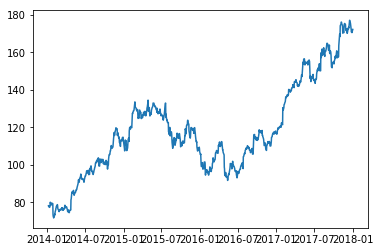

In [662]:
xxx, = plt.plot(f['High'])


In [663]:
def get_return_since_entry(bought_history, current_adj_close, current_day):
    '''
    Calculate the returns of current share holdings.
    INPUTS:
    bought_history(list) 
    current_adj_close(float)
    current_day(int)
    OUTPUTS:
    return_since_entry(float)
    '''
    return_since_entry = 0.
    
    for day, b in bought_history:
        return_since_entry += (current_adj_close - b)
    return return_since_entry

In [675]:
q = initialize_q_mat(all_states, all_actions)/1e7
print('starting q')
print(q)

starting q
                   0             1             2
states                                          
000     8.620607e-08  4.016008e-08  6.192709e-08
001     1.891440e-08  8.173119e-08  9.466581e-08
002     2.542269e-08  6.286448e-08  5.287235e-09
003     2.057047e-08  9.549392e-08  7.681905e-09
004     9.169196e-09  6.446150e-08  2.829691e-08
005     5.860194e-08  2.999314e-08  1.089946e-08
006     4.036604e-08  5.843087e-08  6.244836e-08
007     1.514033e-08  8.303976e-08  5.239020e-08
008     1.743921e-08  8.531742e-08  2.511772e-08
009     2.229999e-08  8.560898e-09  9.108561e-08
010     1.264120e-08  3.923568e-08  4.110483e-08
011     6.037672e-10  2.516869e-09  9.468920e-08
012     8.443667e-08  3.545601e-08  1.150628e-08
013     3.562651e-08  7.188951e-08  5.122576e-08
014     2.950513e-09  9.747472e-08  1.821152e-08
015     7.081922e-08  2.586454e-08  3.985123e-08
016     2.638165e-08  6.583916e-08  2.432973e-08
017     8.004391e-08  9.232844e-08  4.348695e-08
018     7

In [682]:
cntr = 0

all_data = np.array(f[['Adj Close', 'state']])

actions_history = []

num_shares = 0
alpha = 0.2
gamma = 0.95 # discount_rate
bought_history = [] # (day,price)
returns_since_entry = [0]
days = [0]
data = all_data[iteration*30 : (iteration+1)*30]
for i, val in enumerate(all_data):
    print('day {}，current state {}, '.format(i, state), end=' ') #i, state, next_state

    current_adj_close, state = val
    try:
        next_adj_close, next_state = data[i+1]
    except:
        print('End of data! Done!')
        break


    if len(bought_history) > 0:
        returns_since_entry.append(get_return_since_entry(bought_history, current_adj_close, i)) 
    else:
        returns_since_entry.append(returns_since_entry[-1])
    print('return since entry {}'.format(returns_since_entry[-1]))


    # decide action
    action = act(state, q, threshold=0.2, actions_size=3)

    # get reward
    if action == 0: # hold
        if num_shares > 0:
            reward = next_adj_close - current_adj_close            
        else:
            reward = 0

    if action == 1: # buy
        reward = 0
        num_shares += 1
        bought_history.append((i, current_adj_close))
        print('at price {}'.format(current_adj_close))

    if action == 2: # sell
        if num_shares > 0:
            bought_price = bought_history[0][1]
            bought_history.pop(0)
            reward = current_adj_close - bought_price

            num_shares -= 1
            print('at price {}'.format(current_adj_close))
        else:
            reward = -1
    actions_history.append((i, current_adj_close, action))
    # update q table

    q.loc[state, action] = (1.-alpha)*q.loc[state, action] + alpha*(reward+gamma*(q.loc[next_state].max()))

#     cntr += 1
#     if cntr ==40:
#         break


day 0，current state 631,  return since entry 0
random choice: buy
at price 65.85053
day 1，current state 027,  return since entry -0.470940000000013
max choice: buy
at price 65.37959
day 2，current state 022,  return since entry 0.3571399999999869
max choice: buy
at price 65.79363
day 3，current state 052,  return since entry -2.1633999999999816
max choice: buy
at price 64.95345
day 4，current state 014,  return since entry -3.897079999999974
max choice: hold
day 5，current state 016,  return since entry -2.545919999999981
max choice: buy
at price 64.85782
day 6，current state 052,  return since entry 3.9068800000000152
max choice: buy
at price 66.14838
day 7，current state 097,  return since entry 11.875120000000024
max choice: sell
at price 67.47642
day 8，current state 099,  return since entry 8.36672999999999
max choice: buy
at price 67.09992
day 9，current state 056,  return since entry -1.4975100000000339
max choice: hold
day 10，current state 008,  return since entry 4.604129999999998
max

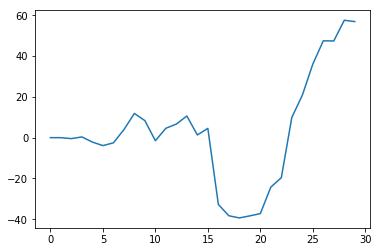

In [683]:
plt.plot(returns_since_entry)

In [637]:
q

,0,1,2
states,,,
000,0.000508,0.000667,0.000756
001,0.000887,0.000790,0.000425
002,0.000464,0.000910,0.000767
003,0.000687,0.000094,0.000475
004,0.000991,0.000629,0.000033
005,0.000276,0.000803,0.000123
006,0.000496,0.000441,0.000558
007,0.000054,0.000990,0.000986
008,0.000714,0.004556,0.000731
